In [1]:
# LOAD LIBRARIES
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(future))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(presto))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(tictoc))

suppressPackageStartupMessages(library(enrichR))
suppressPackageStartupMessages(library(org.Hs.eg.db))
suppressPackageStartupMessages(library(AnnotationDbi))

suppressPackageStartupMessages(library(SingleR))

suppressPackageStartupMessages(library(GPTCelltype))
suppressPackageStartupMessages(library(openai))

In [2]:
total_time <- function(seconds) {
    d <- seconds %/% (86400)
    h <- (seconds %% 86400) %/% 3600
    m <- (seconds %% 3600) %/% 60
    s <- seconds %% 60
    
    cat(sprintf("Total Time: %d Days, %d Hours, %d Minutes and %d Seconds\n", d, h, m, s))
}

In [3]:
load.data <- function(
    file_name,
    data_path = path_to_data,
    output = F,
    reduced.output = T 
) {
    if (output | reduced.output) {
        print(paste("Loading data for time point:", file_name))
    }

    # Load the data
    sc_data <- Read10X(data.dir = paste(data_path, "expression_", file_name, sep = ""), gene.column = 1)

    # Create Seurat object
    sc_data <- CreateSeuratObject(counts = sc_data, min.cells = 3, min.features = 500, project = file_name, names.delim = "-", names.field = 2)

    # Normalize the data
    sc_data <- NormalizeData(sc_data, normalization.method = "LogNormalize", scale.factor = 1e6, verbose = output)

    # Find variable features
    sc_data <- FindVariableFeatures(sc_data, selection.method = "mvp", nfeatures = 2000, verbose = output)

    # Scale the data
    sc_data <- ScaleData(sc_data, verbose = output)

    return(sc_data)
}

In [4]:
PCA.cluster <- function(
    data = sc_data_scaled, 
    file_name = timepoints[time_point], 
    res = 1, 
    n_dim = 40, 
    save = F,
    output = F,
    reduced.output = T    
) {  
    if (output | reduced.output) {
        print(paste("Running PCA and clustering for time point:", file_name))
        print(paste("- Resolution:", res))
        print(paste("- Dimensions:", n_dim))
    }
        
    # PCA
    data <- RunPCA(data, npcs = n_dim, verbose = output)
    #print(ElbowPlot(object = data, ndims = 50))

    # Cluster the cells
    data <- FindNeighbors(data, dims = 1:n_dim, verbose = output)
    data <- FindClusters(data, resolution = res, verbose = output)
    
    #print(table(Idents(data)))

    # Save the parial
    if (save) {
        name_new_dir <- paste("Partial/", file_name, "/cluster", param, sep="")
        if (!dir.exists(name_new_dir)) {dir.create(name_new_dir)} 
    
        print(paste("Saving PCA for time point", file_name, "in", name_new_dir))
        save(data, file = paste(name_new_dir, "/PCA_res_", res, "_dim_", n_dim, "_", file_name, ".Robj", sep=""))
    }
    return(data)
}

In [5]:
UMAP.plot <- function(
    data = sc_data,
    file_name = timepoints[time_point],
    n_dim = 40,
    param = "",
    output = F,
    reduced.output = T,
    print_plot = F
) {
    if (output | reduced.output) {
        print("Making UMAP")
    }
    
    sc_data_UMAP <- RunUMAP(data, dims = 1:n_dim, verbose = output)
    
    # Visualization of clusters   
    plot <- DimPlot(sc_data_UMAP, reduction = "umap", label = TRUE, pt.size = 1) + 
        ggtitle(paste("UMAP of Clusters -",file_name, "-", gsub("_", " ", param)))

    if (print_plot) {print(plot)}
    
    return(plot)
}

In [6]:
# FIND ALL MARKERS
cluster.markers <- function(
    data, 
    file_name = timepoints[time_point],
    output = F,
    reduced.output = T
) {
    if (output | reduced.output) {
        print(paste("Finding all markers for time point:", file_name))
    }

    # Find all markers for every cluster compared to all remaining cells
    markers <- FindAllMarkers(data,
                              only.pos = TRUE,   # Considera solo i marker espressi positivamente
                              min.pct = 0.25,    # Percentuale minima di espressione nelle cellule del cluster
                              logfc.threshold = 0.25,  # Soglia minima di LogFC
                              verbose = output)
        
    return(markers)
}

In [49]:
annotation.enrichR <- function (
    top_genes,
    database = "Allen_Brain_Atlas_10x_scRNA_2021",
    output = F,
    reduced.output = T
) {
    gene_symbols <- top_genes$gene
    # entrez_ids <- suppressMessages(
    #     mapIds(org.Hs.eg.db, keys = gene_symbols, column = "ENTREZID", keytype = "SYMBOL", multiVals = "first")
    # )
    # # Add Entrez IDs to your data.frame
    # top_genes$entrez <- entrez_ids
    # # Remove rows with NA Entrez IDs
    # top_genes <- top_genes[!is.na(top_genes$entrez), ]

    annotation_list <- list()
    
    for (cl in unique(top_genes$cluster)) {
        genes_cluster <- top_genes %>% filter(cluster == cl) %>% pull(gene)#entrez)
        # Optionally, use Entrez IDs instead:
        # genes_cluster <- top_genes %>% filter(cluster == cl) %>% pull(entrez)
        
        # Perform enrichment analysis
        a <- capture.output(
            enriched <- enrichr(genes_cluster, databases = "Allen_Brain_Atlas_10x_scRNA_2021")
        )

        annotation <- enriched$Allen_Brain_Atlas_10x_scRNA_2021 %>% as.data.table()
        annotation$cluster <- as.numeric(cl)

        annotation_list[[cl]] <- annotation[grepl("Human", annotation$Term, ignore.case = TRUE) & annotation$Adjusted.P.value < 5e-2]
    }


    return(annotation_list)
}

In [8]:
iterations <- function(
    timepoints = c("23days", "1month", "1.5month", "2month", "3month", "4month", "5month", "6month"),
    housekeeping_genes = c("ACTB", "DLG4"),
    genes_of_interest = c("SRCIN1", "KIAA1217", "CIT"),
    path_to_data = "/sharedFolder/Data/",
    res_list = seq(0.1, 1, by = 0.1),
    dim_list = c(20, 30, 40, 50),
    top_n_genes = 50,
    check_for_saved_plot = F,
    output = F,
    reduced.output = T,
    print.plot = F
) {
    print(paste("Path to data:", path_to_data))
    print(paste("Timepoints:", timepoints))
    print(paste("Housekeeping genes:", housekeeping_genes))
    print(paste("Genes of interest:", genes_of_interest))
    print("")

    print(paste("Resolutions:", res_list))
    print(paste("Number of dimension:", dim_list))
    print("")
    
    # Total number of 
    cycles_per_timepoint <- length(res_list)*length(dim_list)
    print(paste("Number of cycles per timepoint:", cycles_per_timepoint))
    tot_cycles <- cycles_per_timepoint*length(timepoints)
    print(paste("Total number of cycles:", tot_cycles))
    print("")
    
    N_cycle <- 0
    
    dir_iterations <- paste0("Results/Iterations")     
    if (!dir.exists(dir_iterations)) {dir.create(dir_iterations)}
    
    print("Starting")
    
    timings <- data.frame()
    n_of_clusters <- data.frame()
    
    tic("Iterations")
    
    for (f_name in timepoints) {
        tic(paste("Loading", f_name))
    
        dir_timepoint <- paste(dir_iterations, "/", f_name, sep="")     
        if (!dir.exists(dir_timepoint)) {dir.create(dir_timepoint)}
        
        # Load data
        sc_data_scaled <- load.data(file_name = f_name, data_path = path_to_data, output = output, reduced.output = reduced.output)
    
        toc(quiet = T)
    
        for (clustering_resolution in res_list) {
            for (n_of_dimesnions in dim_list) {
                # Progression Message
                N_cycle <- N_cycle + 1
                print(paste(N_cycle, "of", tot_cycles)) 
                print(paste(f_name, "- Res:", clustering_resolution, "- Dim:", n_of_dimesnions))
    
                # param
                char_res <- as.character(clustering_resolution)
                if (grepl("\\.", char_res)) {char_res <- gsub("\\.", "_", char_res)}
                param <- paste0("_res_", char_res, "_dim_", n_of_dimesnions)
    
                # Create subfolder
                new_dir <- paste(dir_timepoint, "/", f_name, param, sep="")     
                if (!dir.exists(new_dir)) {dir.create(new_dir)}
    
                # start time
                tic(paste(f_name, "- Res:", clustering_resolution, "- Dim:", n_of_dimesnions))
    
                # Clusterize
                sc_data <- PCA.cluster(
                    data = sc_data_scaled, 
                    file_name = f_name, 
                    res = clustering_resolution, 
                    n_dim = n_of_dimesnions,
                    output = output, 
                    reduced.output = reduced.output
                )
    
                n_of_clusters[paste0("res_", clustering_resolution, "_dim_", n_of_dimesnions), f_name] <- length(table(Idents(sc_data)))
    
                plot_UMAP <- suppressMessages(suppressWarnings(UMAP.plot(
                    data = sc_data, 
                    file_name = f_name, 
                    n_dim = n_of_dimesnions, 
                    param = param,
                    output = output, 
                    reduced.output = reduced.output,
                    print_plot = print.plot
                )))

                # Save UMAP
                umap_file_name <- paste0(new_dir, "/UMAP", f_name, param, ".png")
                if (!(check_for_saved_plot & exists(umap_file_name))) {
                    print("Saving UMAP")
                    ggsave(
                        umap_file_name, 
                        plot=plot_UMAP, 
                        width = 1920*2, height = 1980*2, units = "px"
                    )
                }
    
                # Find Markers
                cluster_markers <- cluster.markers(
                    data = sc_data, 
                    file_name = f_name, 
                    output = output, 
                    reduced.output = reduced.output
                )
    
                write.csv(cluster_markers, file = paste0(
                    new_dir, "/",
                    "cluster_markers_",
                    f_name,
                    param,
                    ".csv"
                ))

                # de.genes
                de_genes <- cluster_markers %>% filter(gene %in% genes_of_interest)
                if (output | reduced.output) {print(paste("de.genes nrow:", nrow(de_genes)))}

                write.csv(de_genes, file = paste0(
                    new_dir, "/",
                    "de_genes",
                    f_name,
                    param,
                    ".csv"
                ))

                # Top top_n_genes DE genes
                top_genes_by_cluster <- cluster_markers %>% group_by(cluster) %>% top_n(n = top_n_genes, wt = avg_log2FC) %>% as.data.frame()

                write.csv(top_genes_by_cluster, file = paste0(
                    new_dir, "/",
                    "top_genes_by_cluster_",
                    f_name,
                    param,
                    ".csv"
                ))
    
                # Annotation - enrichR
                enrichR_list <- annotation.enrichR(
                    top_genes = top_genes_by_cluster,
                    database = "Allen_Brain_Atlas_10x_scRNA_2021"
                )

                write.csv(bind_rows(enrichR_list), file = paste0(
                    new_dir, "/",
                    "enrichR_annotation_",
                    f_name,
                    param,
                    ".csv"
                ), row.names = FALSE)
    
                # Annotation - singelR
    
                # Annotation - CPTCellType
    
                # end time
                elapsed <- toc(log = TRUE, quiet = T)
                timings[f_name, paste0("res_", clustering_resolution, "_dim_", n_of_dimesnions)] <- elapsed$toc - elapsed$tic
            }
        }

        print("") # an empti line for better visualization 
    }

    timings$tot_time <- rowSums(timings)

    write.csv(timings, file = paste0(dir_iterations, "/tmings.csv"))
    
    n_tocken_gpt <- n_of_clusters*837.5
    n_tocken_gpt$total <- rowSums(n_tocken_gpt)

    write.csv(n_tocken_gpt, file = paste0(dir_iterations, "/number_of_tokens.csv"))
    
    tot_elapsed <- toc(log = TRUE, quiet = F)
    print("END")
    return(list(timings, n_of_clusters))
}

In [9]:
# tic("Iterations")
# tmp <- capture.output(
#     iterations <- iterations(
#         timepoints = c("23days", "1month", "1.5month", "2month", "3month", "4month", "5month", "6month"),
#         housekeeping_genes = c("ACTB", "DLG4"),
#         genes_of_interest = c("SRCIN1", "KIAA1217", "CIT"),
#         path_to_data = "/sharedFolder/Data/",
#         res_list = seq(0.1, 1, by = 0.1),
#         dim_list = c(20, 30, 40, 50),
#         top_n_genes = 50,
#         check_for_saved_plot = T,
#         output = F, 
#         reduced.output = T, 
#         print.plot = F
#     ),
#     file = "/sharedFolder/Paper_clusters_from_scratch/Results/Iterations/0_output.txt"
# )

# elapsed <- toc(log = TRUE, quiet = T)
# total_time(elapsed$toc - elapsed$tic)

# print(iterations)

In [10]:
timepoints = c("23days", "1month", "1.5month", "2month", "3month", "4month", "5month", "6month")
housekeeping_genes = c("ACTB", "DLG4")
genes_of_interest = c("SRCIN1", "KIAA1217", "CIT")
path_to_data = "/sharedFolder/Data/"
res_list = seq(0.1, 1, by = 0.1)
dim_list = c(20, 30, 40, 50)
top_n_genes = 50
check_for_saved_plot = F
output = F
reduced.output = T
print.plot = F

In [11]:
timings <- data.frame()
n_of_clusters <- data.frame()

In [12]:
f_name <- timepoints[2]

In [13]:
tic()
sc_data_scaled <- load.data(file_name = f_name, data_path = path_to_data, output = output, reduced.output = reduced.output)
toc()

[1] "Loading data for time point: 1month"


Warning message:
“Input parameters result in NA values for initial cell identities. Setting all initial idents to the project name”


76.49 sec elapsed


In [14]:
clustering_resolution <- res_list[5]
n_of_dimesnions <- dim_list[2]
clustering_resolution
n_of_dimesnions

[1] 0.5

[1] 30

In [15]:
# param
char_res <- as.character(clustering_resolution)
if (grepl("\\.", char_res)) {char_res <- gsub("\\.", "_", char_res)}
param <- paste0("_res_", char_res, "_dim_", n_of_dimesnions)

In [16]:
tic()
# Clusterize
sc_data <- PCA.cluster(
    data = sc_data_scaled, 
    file_name = f_name, 
    res = clustering_resolution, 
    n_dim = n_of_dimesnions,
    output = output, 
    reduced.output = reduced.output
)
toc()
table(Idents(sc_data))

[1] "Running PCA and clustering for time point: 1month"
[1] "- Resolution: 0.5"
[1] "- Dimensions: 30"
37.159 sec elapsed


In [17]:
n_of_clusters[paste0("res_", clustering_resolution, "_dim_", n_of_dimesnions), f_name] <- length(table(Idents(sc_data)))
n_of_clusters

,1month
,<int>
res_0.5_dim_30,25


[1] "Making UMAP"
44.994 sec elapsed


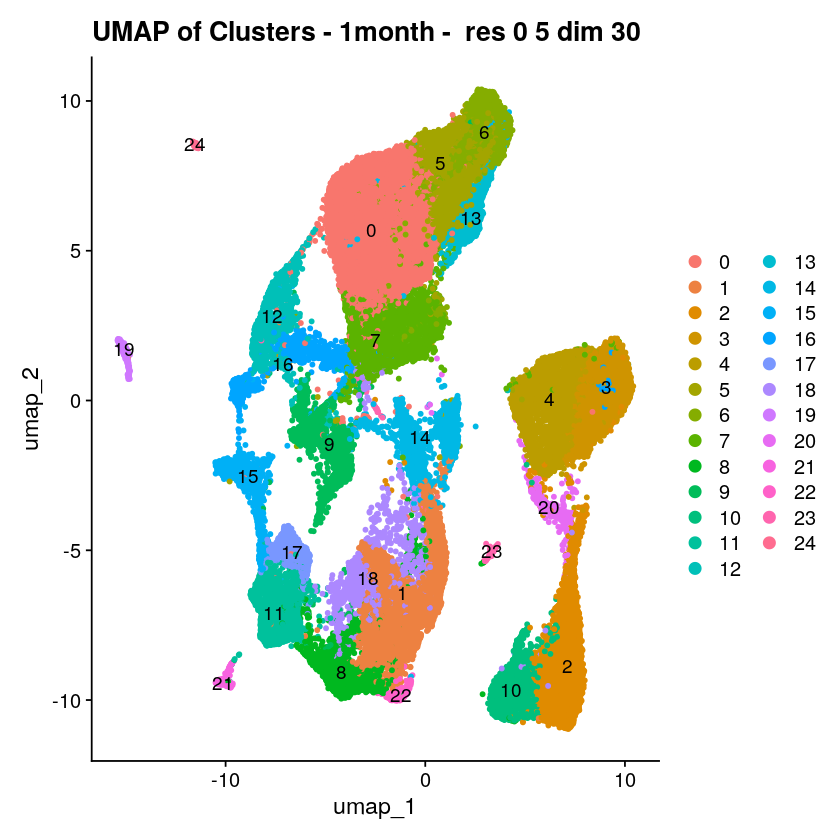

In [18]:
tic()
# UMAP
plot_UMAP <- suppressMessages(suppressWarnings(UMAP.plot(
    data = sc_data, 
    file_name = f_name, 
    n_dim = n_of_dimesnions, 
    param = param,
    output = output, 
    reduced.output = reduced.output,
    print_plot = T # __________________________________________print.plot__________________________________
)))
toc()

In [19]:
tic()
# Find Markers
cluster_markers <- cluster.markers(
    data = sc_data, 
    file_name = f_name, 
    output = output, 
    reduced.output = reduced.output
)
toc()

In [21]:
tic()
cluster_markers <- FindAllMarkers(
    sc_data,
    only.pos = TRUE,   # Considera solo i marker espressi positivamente
    min.pct = 0.25,    # Percentuale minima di espressione nelle cellule del cluster
    logfc.threshold = 0.25,  # Soglia minima di LogFC
    verbose = T
)
toc()

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating cluster 19

Calculating cluster 20

Calculating cluster 21

Calculating cluster 22

Calculating cluster 23

Calculating cluster 24



277.004 sec elapsed


In [42]:
head(cluster_markers)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
ADRA2A,0,1.839142,0.489,0.155,0,0,ADRA2A
MCM6,0,1.814712,0.519,0.155,0,0,MCM6
MCM5,0,1.722702,0.618,0.194,0,0,MCM5
ADAMTS6,0,1.703055,0.354,0.121,0,0,ADAMTS6
SEL1L3,0,1.686606,0.270,0.094,0,0,SEL1L3
PRKCB,0,1.681937,0.657,0.233,0,0,PRKCB


In [22]:
# de.genes
de_genes <- cluster_markers %>% filter(gene %in% genes_of_interest)
if (output | reduced.output) {print(paste("de.genes nrow:", nrow(de_genes)))}
de_genes

[1] "de.genes nrow: 3"


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
CIT,0.000000e+00,2.688170,0.340,0.048,0.000000e+00,6,CIT
SRCIN1,1.515352e-230,2.174987,0.254,0.069,3.857329e-226,11,SRCIN1
KIAA1217,0.000000e+00,1.838169,0.310,0.074,0.000000e+00,13,KIAA1217


In [43]:
# Top top_n_genes DE genes
top_genes_by_cluster <- cluster_markers %>% group_by(cluster) %>% top_n(n = 20, wt = avg_log2FC) %>% as.data.frame()

In [44]:
top_genes <- top_genes_by_cluster
# gene_symbols <- top_genes$gene
# entrez_ids <- suppressMessages(
#     mapIds(org.Hs.eg.db, keys = gene_symbols, column = "ENTREZID", keytype = "SYMBOL", multiVals = "first")
# )
# # Add Entrez IDs to your data.frame
# top_genes$entrez <- entrez_ids
# # Remove rows with NA Entrez IDs
# top_genes <- top_genes[!is.na(top_genes$entrez), ]



genes_cluster <- top_genes %>% filter(cluster == 0) %>% pull(gene)
as.data.frame(genes_cluster)
genes_cluster

genes_cluster
<chr>
ADRA2A
MCM6
MCM5
ADAMTS6
SEL1L3
PRKCB
CDCA7
B3GAT2
STOX1


[1] "ADRA2A"  "MCM6"    "MCM5"    "ADAMTS6" "SEL1L3"  "PRKCB"   "CDCA7"  
 [8] "B3GAT2"  "STOX1"   "GAS1"    "FAM111B" "CTSC"    "RASGRP1" "OLFM3"  
[15] "GLI3"    "MCM3"    "UNG"     "LRRC3B"  "ROR1"    "MSH6"

In [45]:
genes_cluster

[1] "ADRA2A"  "MCM6"    "MCM5"    "ADAMTS6" "SEL1L3"  "PRKCB"   "CDCA7"  
 [8] "B3GAT2"  "STOX1"   "GAS1"    "FAM111B" "CTSC"    "RASGRP1" "OLFM3"  
[15] "GLI3"    "MCM3"    "UNG"     "LRRC3B"  "ROR1"    "MSH6"

In [46]:
enriched <- enrichr(genes_cluster, databases = "Allen_Brain_Atlas_10x_scRNA_2021")
enriched

Uploading data to Enrichr... Done.
  Querying Allen_Brain_Atlas_10x_scRNA_2021... Done.
Parsing results... Done.


Term,Overlap,P.value,Adjusted.P.value,Old.P.value,Old.Adjusted.P.value,Odds.Ratio,Combined.Score,Genes
<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>
Mouse 232 L6 IT ENTl up,1/12,0.01193737,0.1634285,0,0,95.545455,423.08305,ROR1
Mouse 53 Vip up,1/14,0.01391373,0.1634285,0,0,80.838057,345.57291,LRRC3B
Mouse 76 Sst down,1/14,0.01391373,0.1634285,0,0,80.838057,345.57291,PRKCB
Mouse 21 Ndnf HPF down,1/22,0.02178169,0.1634285,0,0,50.022556,191.42059,PRKCB
Human Inh L1-6 VIP SLC7A6OS down,1/24,0.02373934,0.1634285,0,0,45.668192,170.82742,PRKCB
Human Inh L5-6 SST C4orf26 down,1/25,0.02471677,0.1634285,0,0,43.763158,161.93564,PRKCB
Human Inh L2 PAX6 FREM2 down,1/27,0.02666885,0.1634285,0,0,40.392713,146.39366,PRKCB
Mouse 91 Sst up,1/27,0.02666885,0.1634285,0,0,40.392713,146.39366,LRRC3B
Mouse 66 Sst up,1/28,0.02764349,0.1634285,0,0,38.894737,139.56851,LRRC3B


In [47]:
annotation <- enriched$Allen_Brain_Atlas_10x_scRNA_2021 %>% as.data.table()
#annotation$cluster <- as.numeric(0)
#annotation_list <- list()
annotation_list <- annotation[grepl("Human", annotation$Term, ignore.case = TRUE) & annotation$Adjusted.P.value < 5e-2]
annotation_list

Term,Overlap,P.value,Adjusted.P.value,Old.P.value,Old.Adjusted.P.value,Odds.Ratio,Combined.Score,Genes
<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>


In [48]:
min(annotation_list[[1]]$Adjusted.P.value)

[1] 0.1634285

In [ ]:
# Annotation - enrichR
tic()
enrichR_list <- (annotation.enrichR(
    top_genes = top_genes_by_cluster,
    database = "Allen_Brain_Atlas_10x_scRNA_2021"
))
toc()
enrichR_list